# Fitting Scaling Relationships with ScaleRPy

This notebook provides examples for using the ScaleRPy package for fitting ridge line scaling relationships

Created by Bryanne McDonough

In [38]:
%reload_ext autoreload
%autoreload 2   
import ScaleRPy as sr
#fit_funcs contains the general fitting functions, including finding the ridge points and fitting the ridge points (single linear and double linear currently supported)
from ScaleRPy.fitting import fit_funcs as fit
#The SpatGalDat class is used to load in spatially-resolved data and perform the ridge point finding and fitting, as well as producing a plot
from ScaleRPy.man_dat import SpatGalDat
#formatting includes functions for plotting density contours and selecting colorblind friendly colorschemes
from ScaleRPy.formatting import tol_colors as tol
from ScaleRPy.formatting import density_contours as dc

import numpy as np
import matplotlib.pyplot as plt


## Spatially Resolved Data

ScaleRPy can be used to fit scaling relations to spatially resolved datasets, including spaxels from integral field spectroscopy observations or elements from maps generated from simulated data.

The ridge line method fits functions to the *ridge* of a "3D" distribution of data. The ridge line method better captures the actual scaling relationships because it is less biased by assymetric skewing of data around the scaling relationship. This assymetric skewing is often seen when there are processes that act to shift galaxies or regions of galaxies (as captured in spaxels) off of the scaling relationship. For example, as star formation quenching occurs, star formation rates move down off the scaling relationship (star formation main sequence).

**Step 0: Generating Synthetic Data**

In this example, we will first create synthetic data for spaxels on the resolved star formation main sequence. This data will have known fitting parameters.

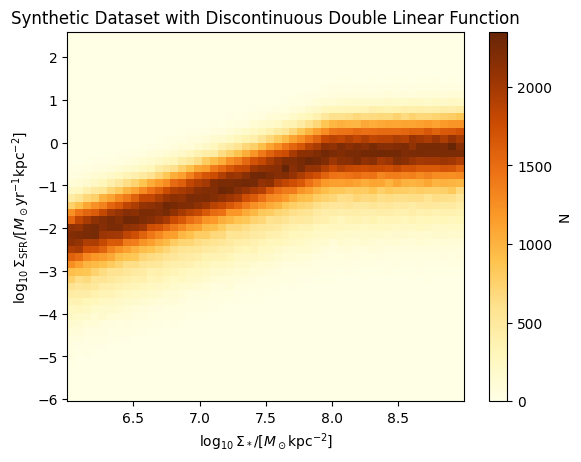

In [40]:
# Generate random values of logged stellar mass surface density in the range (6, 9)
np.random.seed(26)
x = np.random.uniform(6, 9, 1000000)

# A piecewise double linear function is defined in the fit_funcs module
#Define the paramater values [low-mass slope, low-mass intercept, high-mass slope, turnover point]
known_params = [1, -8.2, 0.1, 8]

# Apply the piecewise linear function to the x values
y = np.array([fit.doubline(xi, *known_params) for xi in x])

# Add symmetric noise to the y values
symmetric_noise = np.random.normal(0, 0.5, y.shape)

# Apply the symmetric noise to the y values
y_noisy = y + symmetric_noise

# Select 25% of the points to apply additional skewed noise (to roughly mimic effect of quenching)
num_points = len(y)
np.random.seed(26)
indices = np.random.choice(num_points, size=int(0.25 * num_points), replace=False)

# Add additional skewed noise to the selected points (dragging them to lower values)
additional_noise = np.random.normal(-1.0, 0.5, len(indices))
y_noisy[indices] += additional_noise

#Call a colorblind friendly color map from the tol_colors module
cmap = tol.tol_cmap('YlOrBr')

# Plot the synthetic dataset as a 2D histogram 
plt.hist2d(x, y_noisy, bins=50, cmap=cmap)
plt.xlabel(r'$\log_{10} \Sigma_* / [M_\odot \mathrm{kpc}^{-2}]$')
plt.ylabel(r'$\log_{10} \Sigma_{\mathrm{SFR}} / [M_\odot \mathrm{yr}^{-1} \mathrm{kpc}^{-2}]$')
plt.title('Synthetic Dataset with Discontinuous Double Linear Function')
plt.colorbar(label='N')
plt.show()

**Step 1: Create SpatGalDat object with the synthetic data**

Natively supports three common spatially-resolved parameters: stellar mass (s_mass), star formation rate (sfr), and gas mass (gas). Additional parameters can be added with SpatGalDat.add_param (for a single additional parameter) or SpatGalDat.add_params for multiple parameters as a dictionary.

In [41]:
#Create a SpatGalDat object with the synthetic data

#converting to float32 is recommended to improve computation time for larger datasets
mass = np.float32(x)
sfr = np.float32(y_noisy)
gas = []
sfr[-1] = np.nan #non-finite values will be converted to NaNs for handling
dat = SpatGalDat(s_mass = mass, sfr = sfr, scale = 'log')
print(dat.sfr)


[-1.7521995  -0.49506837  0.19158855 ... -1.4765309  -0.9311646
         nan]


In [4]:
#Identify the default units:
print(dat.s_mass_unit)
print(dat.sfr_unit)
#print(dat.gas_unit)

$M_\odot \mathrm{kpc}^{-2}$
$M_\odot \mathrm{yr}^{-1} \mathrm{kpc}^{-2}$


The default units will be used to label the axes of our formal plots. You can update the units manually:


In [5]:
dat.s_mass_unit = r'$M_\odot \mathrm{kpc}^{-2}$'
print(dat.s_mass_unit)

$M_\odot \mathrm{kpc}^{-2}$


In [6]:
#check which parameters have been set
print(dat.parameters.keys())

dict_keys(['stellar_mass', 'sfr', 'gas_mass'])


**Step 2: Find the ridge using default settings**

The following code block may take several minutes to run, depending on the size of the datasets. 

There are a couple of computationally-expensive processes running behind the scenes. By default, the x data is sorted into 40 bins. In each bin, a kernel density estimate is computed over all points within that bin to identify a maximum value. Additionally, if contouring=True a kernel density estimate is performed over the entire data set in order to draw contours

In [ ]:
out = dat.SFMS_ridge(xrange=(6,9),fittype='kde', contouring=False, numxbins=30)

**Step 3: Check the parameters obtained by the fit**

When SpatGalDat.SFMS_ridge() is run, the three outputs will be the histogram, the paramaters, and the error on those parameters. Parameters for defined functions are also stored as object variables:


In [43]:
# Extract the parameters and errors from the dat object
fitted_params = dat.SFMS_params
param_errors = dat.SFMS_paramerr

param_list = ['Low-mass slope', 'Low-mass intercept', 'High-mass slope', 'Turnover point']

# Compare the known parameters to the fitted parameters
for i, (param_name, known, fitted, error) in enumerate(zip(param_list, known_params, fitted_params, param_errors)):
    if abs(known - fitted) <= error:
        result = "agree"
    else:
        result = f"do not agree (difference = {abs(known - fitted):.4f})"
    print(f"{param_name}: Known value = {known}, Fitted value = {fitted:.4f}, Error = {error:.4f} -> The values {result} within the error range.")

Low-mass slope: Known value = 1, Fitted value = 0.9932, Error = 0.0118 -> The values agree within the error range.
Low-mass intercept: Known value = -8.2, Fitted value = -8.2149, Error = 0.0826 -> The values agree within the error range.
High-mass slope: Known value = 0.1, Fitted value = 0.0935, Error = 0.0310 -> The values agree within the error range.
Turnover point: Known value = 8, Fitted value = 8.0158, Error = 0.0245 -> The values agree within the error range.


As we can see, find_ridge() works fairly well despite the scatter introduced in our data. All of the parameters agree with the known values within 1 sigma, with the exception of the low-mass y-intercept, which agrees only within 2sigma. 

Examples to add in later iterations:

- Different fitting functions
- Optional formatting choices
- Working with generic parameters
- plot suppression

## Global (i.e., integrated) relationships

Prior to the advent of integral field spectroscopy and high-resolution simulations, scaling relationships were mostly explored for properties integrated over entire galaxies. These scaling relationships are important for understanding galaxy evolution and comparing simulation outputs to reality.

ScaleRPy supports identification of scaling relationships in global data using the ridge line method.

**Step 0: Creating synthetic data**

Let's create a synthetic dataset of measurements of stellar mass and black hole mass for some population of galaxies. Let's assume the stellar to black hole mass scaling relation is linear in logarithmic space and is parameterized as:

$\log(M_{BH}/M_\odot) = \alpha \log(M_*/  M_\odot) - \beta$  

with $ \alpha = 1.2; \beta=-4$

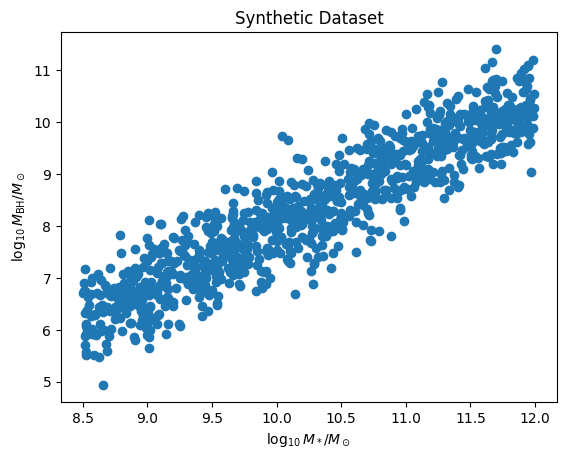

In [44]:
#Set seed for reproducability
np.random.seed(26)
# Generate 1,000 random values of logged stellar mass in the range (8.5, 12)
x = np.random.uniform(8.5, 12, 1000)

# A single linear function is defined in the fit_funcs module
#Define the paramater values [slope, intercept]]
known_params = [1.2, -4]

# Apply the piecewise linear function to the x values
y = np.array([fit.line(xi, *known_params) for xi in x])

np.random.seed(26)
# Add symmetric noise to the y values
symmetric_noise = np.random.normal(0, 0.5, y.shape)

# Apply the symmetric noise to the y values
y_noisy = y + symmetric_noise

#Call a colorblind friendly color map from the tol_colors module
cmap = tol.tol_cmap('YlOrBr')

# Plot the synthetic dataset as a 2D histogram 
plt.scatter(x, y_noisy)
plt.xlabel(r'$\log_{10} M_* / M_\odot$')
plt.ylabel(r'$\log_{10} M_{\rm BH} / M_\odot$')
plt.title('Synthetic Dataset')
#plt.colorbar(label='N')

plt.show()

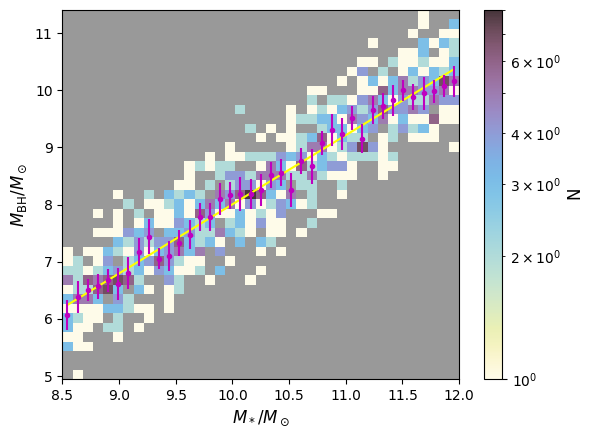

In [54]:
from ScaleRPy.man_dat import GalDat as GD

#Create a GalDat object
#Unlike SpatGalDat, there are not pre-specified parameters for the GalDat object
#The user must specify the parameters themselves
g_dat = GD()

#Add the synthetic data as paramaters
#add_parameters takes as input a parameter name, the data, and the label to include on plots
g_dat.add_parameter('s_mass',x, r'$M_* / M_\odot$')
g_dat.add_parameter('bh_mass',y_noisy, r'$M_{\rm BH} / M_\odot$')
#multiple parameters can be added at once using GalDat.add_params

#Compute the relationship between the two parameters, assuming they are fit by a single linear function
hist, params, paramerr = g_dat.compute_relationship('s_mass', 'bh_mass', linefit='single', xrange=(8.5, 12))

In [55]:
# Extract the parameters and errors from the dat object
fitted_params = params
param_errors = paramerr

param_list = ['slope', 'intercept']

# Compare the known parameters to the fitted parameters
for i, (param_name, known, fitted, error) in enumerate(zip(param_list, known_params, fitted_params, param_errors)):
    if abs(known - fitted) <= error:
        result = "agree"
    else:
        result = f"do not agree (difference = {abs(known - fitted):.4f})"
    print(f"{param_name}: Known value = {known}, Fitted value = {fitted:.4f}, Error = {error:.4f} -> The values {result} within the error range.")

slope: Known value = 1.2, Fitted value = 1.2102, Error = 0.0239 -> The values agree within the error range.
intercept: Known value = -4, Fitted value = -4.0984, Error = 0.2471 -> The values agree within the error range.
